<p>
    <h1 style="color:#1A5276;padding-left:115px;padding-bottom:0px;font-size:28px;">AWS IoT Analytics: Analyzing Sensor Data in the Office</h1>
</p>
<p style="color:#1A5276;padding-left:120px;padding-top:0px;position:absolute;top:60px;font-style:italic;font-size:18px"> In this example notebook, we gather and analyze data from a weather sensor in the office.</p>

<h1 style="color:#20B3CD;font-size:20px">Background </h1><div style="float:right;height:7px;background-color:#20B3CD;margin-top:-12px;width:63%"></div>

The data that we use throughout this example was collected from a Raspberry Pi Sense HAT, located by a window on the 8th floor of LowFlyingHawk. A simple Python script periodically collects temperature, humidity, and pressure readings from the Sense HAT, and publishes the data as messages to an MQTT topic served by the AWS IoT Core MQTT broker. From the AWS IoT Analytics service console, we define a channel that subscribes to the topic. A pipeline moves data from the channel to a data store, and a data set query makes that data available to the AWS Python client (boto3).

We can use boto3 to load the data set to a Jupyter notebook and analyze that data!

<h1 style="color:#20B3CD;font-size:20px">Step 1  |  Import prerequisite libraries</h1><div style="float:right;height:7px;background-color:#20B3CD;margin-top:-12px;width:63%"></div>

We need to import some Python libraries to interact with the AWS IoT service, and to work with our data.

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import islice
import boto3
import json
import os
from six.moves.urllib import request

<h1 style="color:#20B3CD;font-size:20px">Step 2  |  Import data </h1><div style="float:right;height:7px;background-color:#20B3CD;margin-top:-12px;width:63%"></div>

Before we load any data from an IoT Analytics dataset to our notebook, we need to initiliaze the client:

In [2]:
# Download the IoT Analytics service model to access the dataset
request.urlretrieve('https://s3.amazonaws.com/iotanalytics-templates/service-2.json', '/home/ec2-user/service-2.json')
service_model_dir = boto3.__file__.replace('boto3/__init__.py', 'botocore/data/iotanalytics/2017-11-27')
os.system('echo %s | %s' % ('', "sudo -S mkdir -p " + service_model_dir))
os.system('echo %s | %s' % ('', "sudo -S cp /home/ec2-user/service-2.json " + service_model_dir + "/service-2.json"))

# Detect the current region and create IoT Analytics client
region_name = json.loads(request.urlopen('http://169.254.169.254/latest/dynamic/instance-identity/document').read().decode())['region']
client = boto3.client('iotanalytics', region_name)

In [3]:
# Define URL and read in data
dataset = "office_dataset"
dataset_url = client.get_dataset_content(datasetName = dataset)['entries'][0]['dataURI']
weather_df = pd.read_csv(dataset_url)

<h1 style="color:#20B3CD;font-size:20px">Step 3  |  Format data </h1><div style="float:right;height:7px;background-color:#20B3CD;margin-top:-12px;width:63%"></div>

Now we can get the data location (URL) for the given dataset and start working with the data:

In [4]:
# Clean up data, calculate moving descriptive statistics
weather_df = weather_df.drop(columns='__dt') # Drop __dt column
metrics = {} # Initialize metrics dictionary
window = 10 # Rolling window interval
for metric in ['temperature','pressure','humidity']:
    key = str(metric)
    obs = weather_df[key]
    timestamp = pd.to_datetime(weather_df['timestamp'])
    mean = obs.rolling(window).mean()
    std = obs.rolling(window).std()
    var = obs.rolling(window).var()
    for i in range(window):
        if i<window:
            mean[i] = obs[:i+1].mean()
            std[i] = obs[:i+1].std()
            var[i] = obs[:i+1].var()
    metrics[key] = pd.DataFrame.from_dict({'obs': obs, 'mav': mean, 'mstd': std, 'mvar':var})
    metrics[key].index = timestamp
    metrics[key] = metrics[key].sort_index()

<h1 style="color:#20B3CD;font-size:20px">Step 4  |  Plot data </h1><div style="float:right;height:7px;background-color:#20B3CD;margin-top:-12px;width:63%"></div>

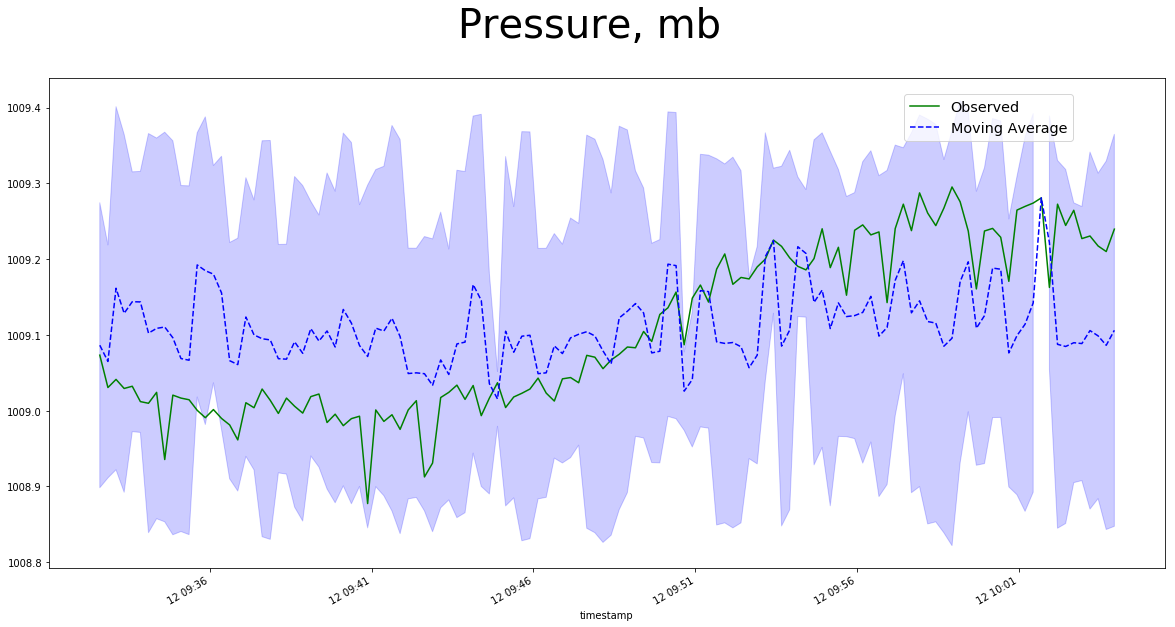

In [5]:
# Pressure Plots
df = metrics['pressure']
obs = df['obs']
mav = df['mav']
mstd = df['mstd']

ax = plt.figure(figsize=[20,10])
obs.plot(color='g')
mav.plot(color='b', ls='dashed')
plt.fill_between(x=mstd.index, y1=mav-2*mstd, y2=mav+2*mstd, color='b', alpha=0.2)
ax.legend(['Observed', 'Moving Average'], fontsize='x-large', fancybox=True, bbox_to_anchor=(0.75, 0.75));
ax.suptitle('Pressure, mb', fontsize=40);

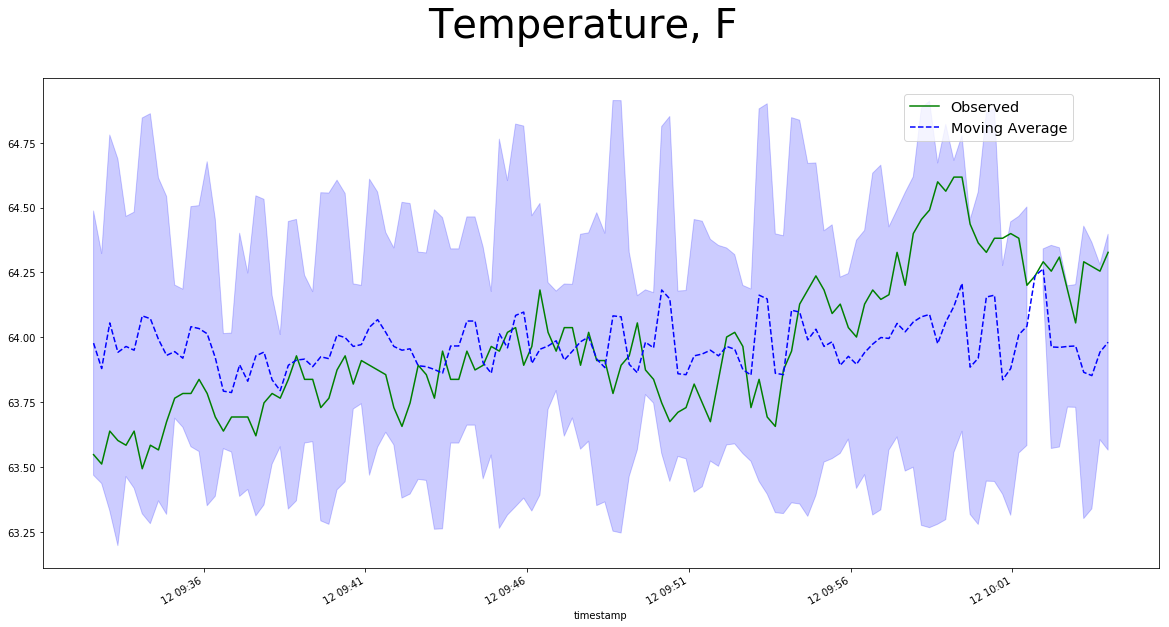

In [6]:
# Temperature plots
df = metrics['temperature']
obs = df['obs']
mav = df['mav']
mstd = df['mstd']

ax = plt.figure(figsize=[20,10])
obs.plot(color='g')
mav.plot(color='b', ls='dashed')
plt.fill_between(x=mav.index, y1=mav-2*mstd, y2=mav+2*mstd, color='b', alpha=0.2)
ax.legend(['Observed', 'Moving Average'], fontsize='x-large', fancybox=True, bbox_to_anchor=(0.75, 0.75));
ax.suptitle('Temperature, F', fontsize=40);

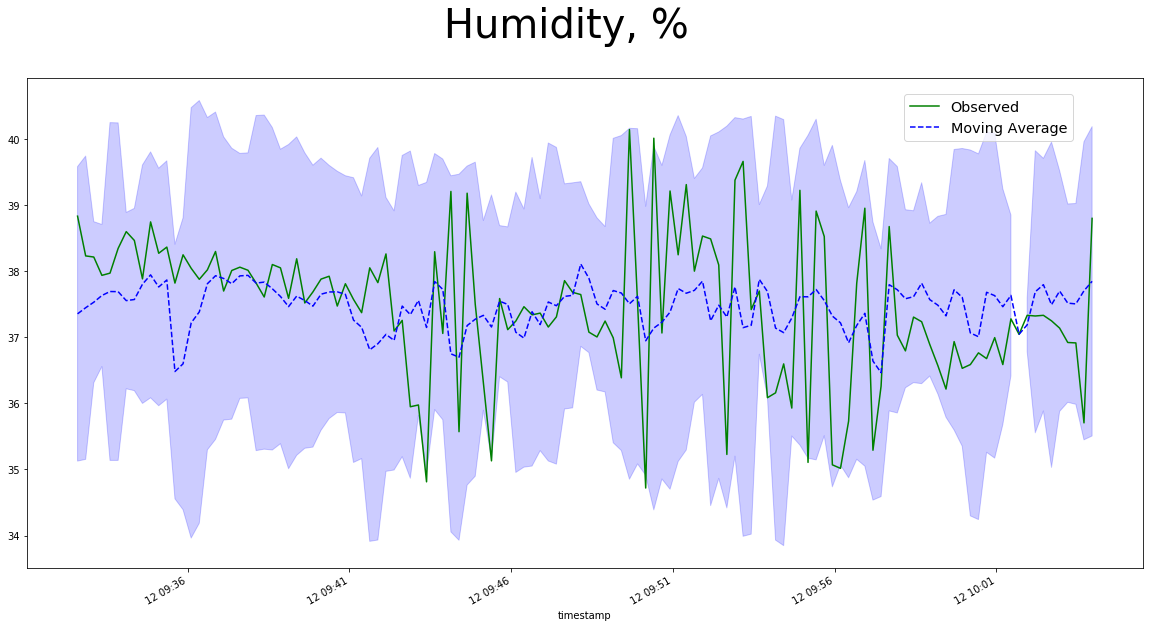

In [7]:
# Humidity plots
df = metrics['humidity']
obs = df['obs']
mav = df['mav']
mstd = df['mstd']

ax = plt.figure(figsize=[20,10])
obs.plot(color='g')
mav.plot(color='b', ls='dashed')
plt.fill_between(mav.index, mav-2*mstd, mav+2*mstd, color='b', alpha=0.2)
ax.legend(['Observed', 'Moving Average'], fontsize='x-large', fancybox=True, bbox_to_anchor=(0.75, 0.75));
ax.suptitle('Humidity, %', fontsize=40);